In [41]:
import pandas as pd
import numpy as np
import inspect

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, normalize, scale
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.svm import LinearSVC

import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#load in the data
cols = pd.read_csv("data/train.csv", nrows=1).columns
train = pd.read_csv("data/train.csv", usecols=cols[2:])
train_target = pd.read_csv("data/train.csv", usecols=["target"])

In [5]:
#check how many binary, categorical and numeric columns there are 
no_binary = list(filter(lambda x: "bin" in x, train.columns))
no_cat = list(filter(lambda x: "cat" in x, train.columns))
no_numeric = list(filter(lambda x: ("cat" not in x) and ("bin" not in x), train.columns))

print(len(no_binary), len(no_cat), len(no_numeric))

17 14 26


Check how many times -1 appears in each column of the training data.

In [44]:
for i in train.columns:
    count = len(train[train[i] == -1])
    #if it has missing values print out the percentage
    if count != 0:
        print(i,"|", "Count:",count, "|","Percentage:" , str(round(100*count/len(train),2)))

ps_ind_02_cat | Count: 216 | Percentage: 0.04
ps_ind_04_cat | Count: 83 | Percentage: 0.01
ps_ind_05_cat | Count: 5809 | Percentage: 0.98
ps_reg_03 | Count: 107772 | Percentage: 18.11
ps_car_01_cat | Count: 107 | Percentage: 0.02
ps_car_02_cat | Count: 5 | Percentage: 0.0
ps_car_03_cat | Count: 411231 | Percentage: 69.09
ps_car_05_cat | Count: 266551 | Percentage: 44.78
ps_car_07_cat | Count: 11489 | Percentage: 1.93
ps_car_09_cat | Count: 569 | Percentage: 0.1
ps_car_11 | Count: 5 | Percentage: 0.0
ps_car_12 | Count: 1 | Percentage: 0.0
ps_car_14 | Count: 42620 | Percentage: 7.16


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d060350>,
      dtype=object)

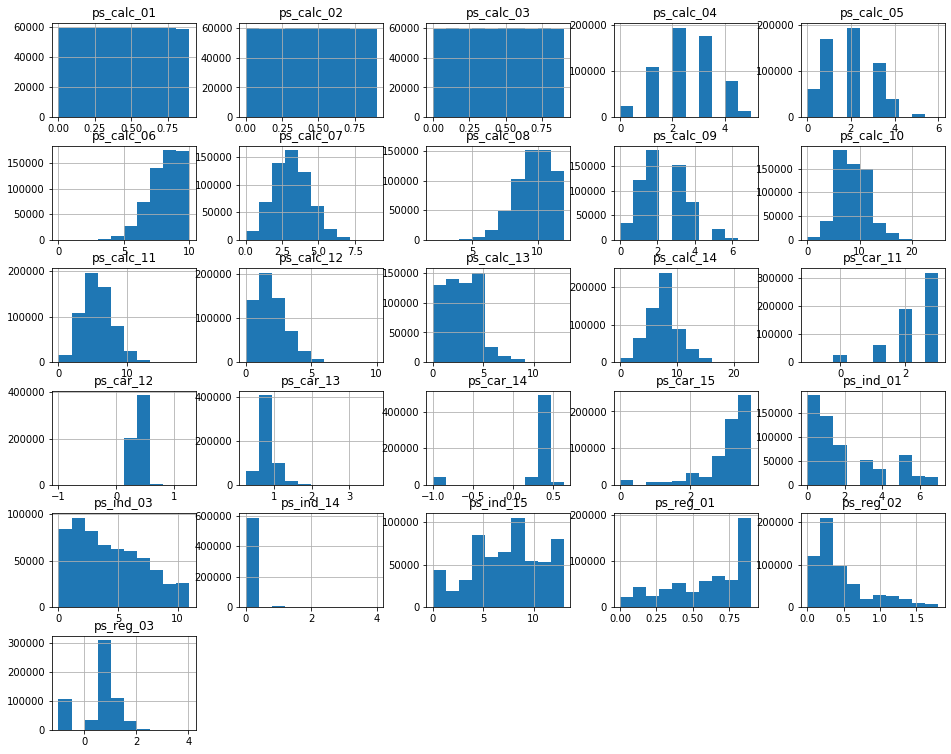

In [4]:
#lets check the distribution of the numerical columns
train[no_numeric].hist(figsize = (16,13))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2a7cf990>,
      dtype=object)

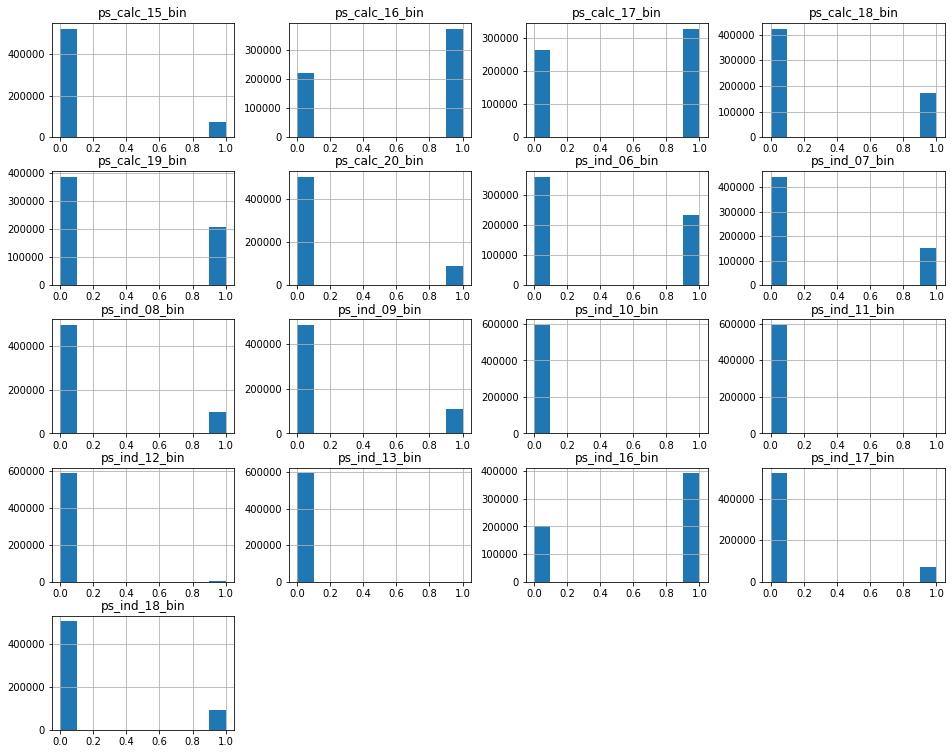

In [49]:
#lets check the distribution of the binary columns
train[no_binary].hist(figsize = (16,13))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a303f3490>,
      dtype=object)

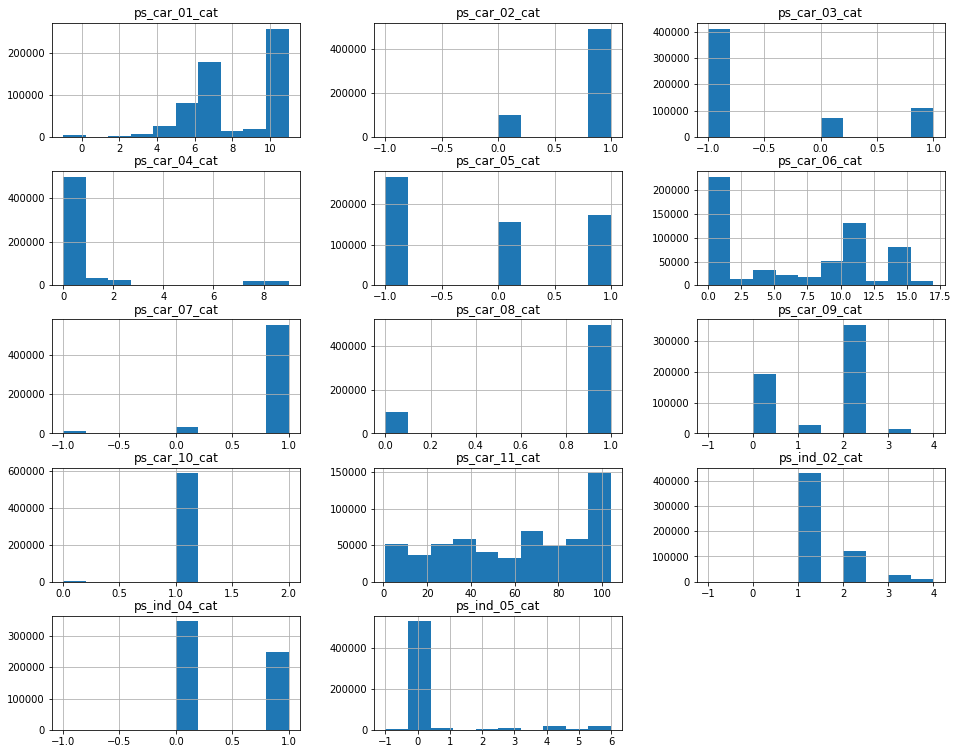

In [53]:
#lets check the distribution of the categorical columns
train[no_cat].hist(figsize = (16,13), layout = (5,3))

In [42]:
#there appears to be a large number of "-1" values in the ps_car_03_cat and ps_car_05_cat. 
#lets check correlation between numerical columns, run line below to see output 
#train[no_numeric].corr() => 26x26 matrix
#some correlation are high, e.g. between the "reg" columns

In [61]:
#check numeric columns summary statistics
train[no_numeric].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,...,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,0.610991,0.439184,0.551102,2.346072,0.379945,0.813265,...,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.287643,0.404264,0.793506,0.832548,0.058327,0.224588,...,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.250619,...,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,0.400000,0.200000,0.525000,2.000000,0.316228,0.670867,...,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,0.700000,0.300000,0.720677,3.000000,0.374166,0.765811,...,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,0.900000,0.600000,1.000000,3.000000,0.400000,0.906190,...,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,0.900000,1.800000,4.037945,3.000000,1.264911,3.720626,...,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


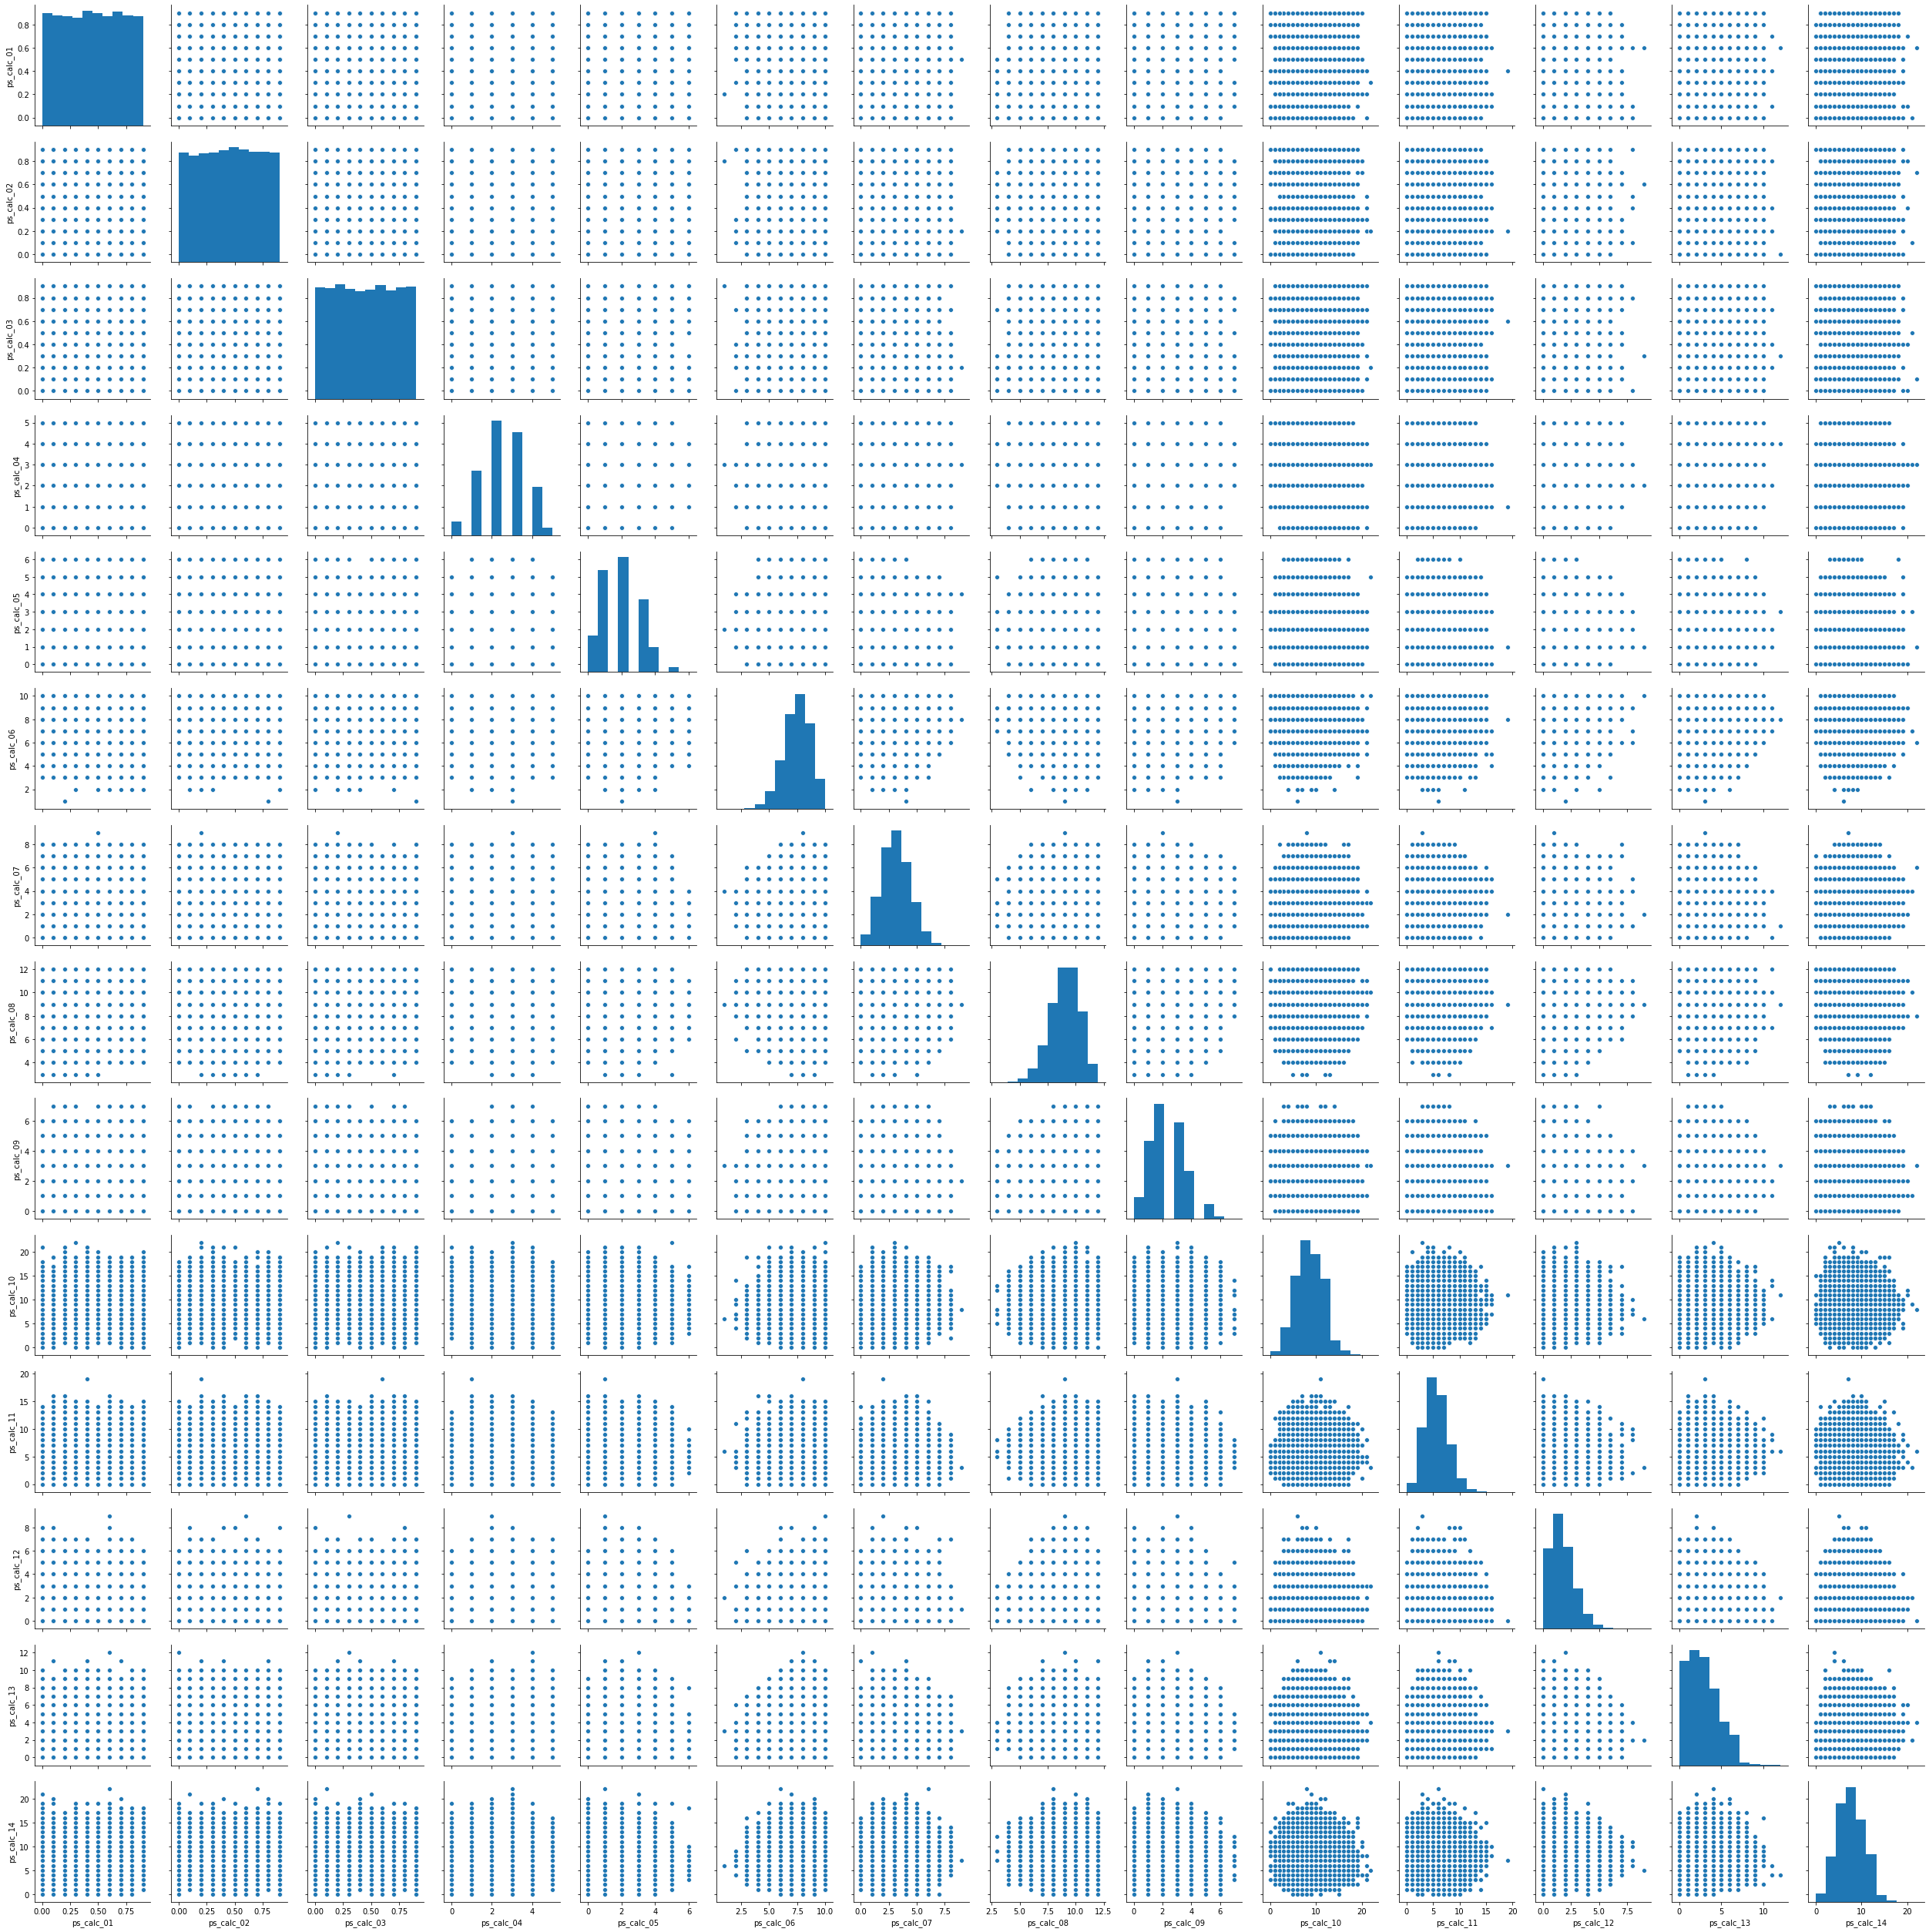

In [23]:
#we know that some columns are grouped, lets do pairs plots of grouped columns 
sns.pairplot(train[list(filter(lambda x: ("calc" in x), no_numeric))][:30000]) #only plotting 30,000 samples

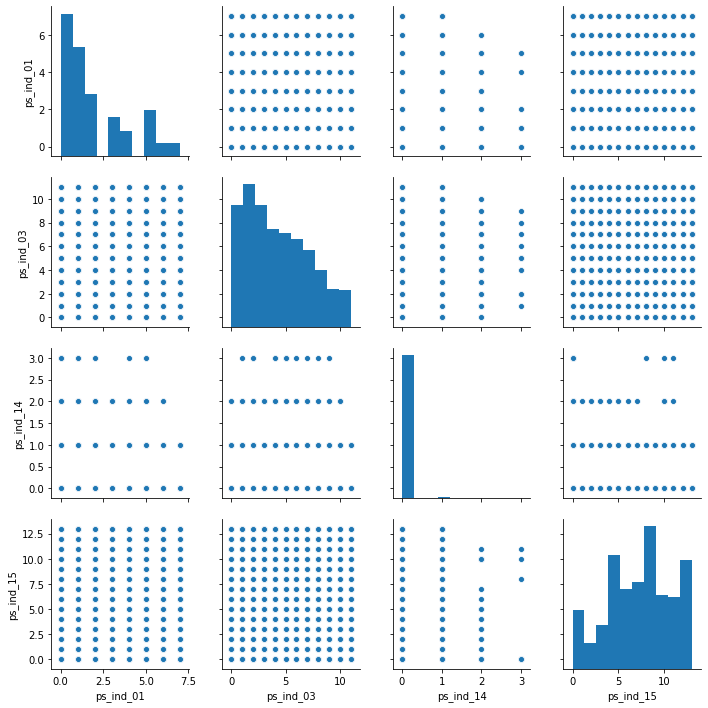

In [94]:
#now lets try with "ind"
sns.pairplot(train[list(filter(lambda x: ("ind" in x), no_numeric))][:60000])

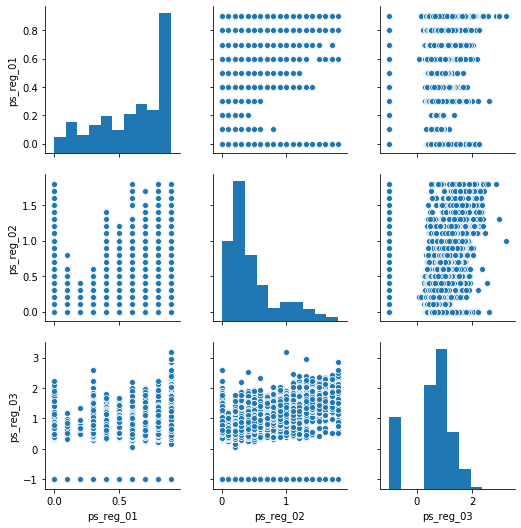

In [89]:
#and "reg"
sns.pairplot(train[list(filter(lambda x: ("reg" in x), no_numeric))][:60000])

In [5]:
#data transformation classes
class ScaleContinuous(BaseEstimator, TransformerMixin):
    
    def __init__(self, scale = "normalize"):
        
        self.scale = scale
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        '''A function scale the continuous numerical columns
           param  X           : the data frame
           type   X           : pandas.core.frame.DataFrame
        '''
        
        #extract all columns that have the word "cat" in them
        num_col_names = [col for col in X if (not col.endswith('cat') and not col.endswith('bin'))]
        num_cols = X[num_col_names]
        
        #extract non numeric columns
        non_num_col_names = [col for col in X if (col.endswith('cat') or col.endswith('bin'))]
        non_num_cols = X[non_num_col_names]
        
        #now apply transformation
        if self.scale == "normalize":
            num_scaled = pd.DataFrame(normalize(num_cols))
        
        elif self.scale == "standardize":
            num_scaled = pd.DataFrame(scale(num_cols ,0))
        
        num_scaled.columns = num_col_names
        
        out = pd.concat([num_scaled, non_num_cols], axis=1)
        
        return out

In [6]:
#one hot encodes categorical columns and give the option to chop out all binary, numeric or categorical columns 
class ExpandCategories(BaseEstimator, TransformerMixin):
    
    def __init__(self, remove_num = False, remove_cat = False , remove_bin = False):
        
        self.remove_num = remove_num
        self.remove_cat = remove_cat
        self.remove_bin = remove_bin
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        '''A function convert the expand categorical variable columns
           param  X           : the data frame
           type   X           : pandas.core.frame.DataFrame
        '''
        #extract all columns that have the word "cat" in them
        cat_names = [col for col in X if col.endswith('cat')]
        cat_cols = X[cat_names]
        
        #extract all continuous
        con_names = [col for col in X if not col.endswith('cat') and not col.endswith('bin')]
        con_cols = X[con_names]
        
        #extract all binary columns
        bin_names = [col for col in X if col.endswith('bin')]
        bin_cols = X[bin_names]
        
        if not self.remove_cat:
            #encode the categorical variables
            enc_X = OneHotEncoder(categories='auto')
            enc_X.fit(cat_cols)
            #set the names of the encoded columns
            cats_encoded = pd.DataFrame(enc_X.transform(cat_cols).toarray())
            cats_encoded.columns = enc_X.get_feature_names(cat_cols.columns.tolist())
        else:
            cats_encoded = cat_cols
        
        out = []
        
        if not self.remove_num:
            out.append(con_cols)
        if not self.remove_cat:
            out.append(cats_encoded)
        if not self.remove_bin:
            out.append(bin_cols)
        
        if len(out) == 0 :
            return pd.DataFrame()
        
        #join the continuous, binary and encoded categorical columns 
        out = pd.concat(out, axis=1)
        
        return out

In [7]:
standardize_expand = Pipeline([
                        ("standardize", ScaleContinuous("normalize")),
                        ("encode_cats", ExpandCategories()),
                        ])
train_ready = standardize_expand.fit_transform(train)

In [8]:
#function to evaluate how a model has performed
def gini(true, predictions):
    """Function to compute gini score given a models prediciton probabilities
    param true        : the true classifications of the data
    param predictions : the prediction probabilities for the data
    """
    
    g = 2*roc_auc_score(true,predictions) - 1
    
    return g

#make a gini scorer that can be passed into cross_validate 
gini_score = make_scorer(gini, greater_is_better=True, needs_proba=True)

Problem can be looked at as a regression problem => modelling the probability that someone makes a claim then using a cut off to classify,
or a classification problem => partitioning up the target into two labels.

Potential models for regression:
* Logisitic Regression (generalised linear model) => sklearn.linear_model.LogisticRegression <br>
* Regularized Regression (LASSO, Ridge, E-Net) => sklearn.linear_model.RidgeClassifier <br>

Classification:
* Decision Tree => sklearn.tree.DecisionTreeClassifier <br>
* SVM => sklearn.svm.LinearSVC <br>
* Neural Network?
